# MBP Tech Talks 2020: Introduction to Medical Image Processing with Python

Let's start by importing the packages we'll be using:
- `numpy`: a library for multi-dimensional array computing
- `SimpleITK`: an image processing toolkit designed with medical imaging in mind
- `matplotlib`: a plotting and visualization package

In [1]:
%matplotlib inline
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (10.0, 10.0) # make the inline plots bigger

## Reading images
The first step in any image analysis workflow is reading the image(s) from disk. Common image storage formats, which also store the required metadata include:
- DICOM (standard format for most clinical CT, MR and PET scans)
- NRRD (format used by (among others) `3D Slicer`)
- NIfTI (popular in the neuroscience community).
`SimpleITK` can handle all of them (in most cases).

The `data` directory in this repository contains a CT scan stored in DICOM format and a segmentation mask in `nrrd` format. Let's load them using `sitk`. Notice that each slice of the 3D image is stored in a separate `.dcm` file (common for DICOM images), while the segmentation is stored in a single file.

The image and segmentation come from MAASTRO LUNG1, a publically-available dataset which you can find [here](https://xnat.bmia.nl/app/template/XDATScreen_report_xnat_projectData.vm/search_element/xnat:projectData/search_field/xnat:projectData.ID/search_value/stwstrategyln1).

In [2]:
image_path = os.path.join("data", "ct")
segmentation_path = os.path.join("data", "segmentation", "segmentation.nrrd")

# get names of all files corresponding to image slices
slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(image_path)  
image = sitk.ReadImage(slice_filenames)

segmentation = sitk.ReadImage(segmentation_path)

## Image and world coordinates

`SimpleITK` images represent objects in space, keeping track of the world coordinate system (origin, direction and spacing). Let's have a look at the geometry properties of our CT image.

In [3]:
image_size = image.GetSize()
image_origin = image.GetOrigin()
image_direction = image.GetDirection()
image_spacing = image.GetSpacing()
print(f"image:\n\tsize = {image_size}\n\torigin = {image_origin}\n\tdirection = {image_direction}\n\tspacing = {image_spacing}")

image:
	size = (512, 512, 134)
	origin = (-249.51171875, -460.51171875, -681.5)
	direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
	spacing = (0.9765625, 0.9765625, 3.0)


Let's check if our segmentation mask maps to the same world coordinates.

In [4]:
segmentation_size = segmentation.GetSize()
segmentation_origin = segmentation.GetOrigin()
segmentation_direction = segmentation.GetDirection()
segmentation_spacing = segmentation.GetSpacing()
print(f"segmentation\n\tsize = {segmentation_size}\n\torigin = {segmentation_origin}\n\tdirection = {segmentation_direction}\n\tspacing = {segmentation_spacing}")

segmentation
	size = (512, 512, 134)
	origin = (-249.51171874999994, -460.5117187499999, -681.4999999999999)
	direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
	spacing = (0.9765624999999998, 0.9765624999999998, 2.999999999999999)


Images can also be used to convert between image and world coordinates using the stored geometry metadata.

In [5]:
image_point = (0, 0, 0) # a point in image coordinates
world_point = image.TransformIndexToPhysicalPoint(image_point) # the same point in world coordinates
image_point2 = image.TransformPhysicalPointToIndex(world_point) # back to image coordinates
print(f"world coordinates of {image_point}: {world_point}")
print(f"image coordinates of {world_point}: {image_point2}")
print(f"image origin in world coordinates: {image.GetOrigin()}")

world coordinates of (0, 0, 0): (-249.51171875, -460.51171875, -681.5)
image coordinates of (-249.51171875, -460.51171875, -681.5): (0, 0, 0)
image origin in world coordinates: (-249.51171875, -460.51171875, -681.5)


## Indexing

In the image space, `SimpleITK` uses the `xyz` indexing convention. The first axis corresponds to width, the second to height and the third to depth (slice number). You can access various parts of the image using syntax similar to `numpy` indexing.

In [6]:
origin_voxel = image[0, 0, 0] # get value of the image origin voxel, i.e. the upper left corner of the first slice
middle_slice = image[:, :, image.GetSize()[2] // 2] # extract the middle slice of the image
cropped_middle_slice = middle_slice[50:-50, 50:-50] # crop 50 pixels from each side
print(f"origin voxel value: {origin_voxel}")
print(f"middle slice size: {middle_slice.GetSize()}")
print(f"cropped middle slice size: {cropped_middle_slice.GetSize()}")

origin voxel value: -1024
middle slice size: (512, 512)
cropped middle slice size: (412, 412)


## Converting between `SimpleITK` and `numpy` 

Conversion between `SimpleITK` images and `numpy.ndarray`s is done using `sitk.GetArrayFromImage` and `sitk.GetImageFromArray`. This is useful if you want to apply algorithms implemented in other libraries, or for image visualization.

**Important:** there are 2 major differences between `SimpleITK` images and `numpy` arrays, which are often a source of confusion and hard-to-trace bugs.
1. When converting a `sitk` image to `numpy` array, the indexing order is *reversed* (`xyz` for `sitk` vs `zyx` for numpy).

In [7]:
array_from_image = sitk.GetArrayFromImage(image)
print(f"image size: {image.GetSize()}")
print(f"array size: {array_from_image.shape}")

image size: (512, 512, 134)
array size: (134, 512, 512)


2. Converting to `numpy` array discards the geometry information, unless you explicitly store it separately. Furthermore, converting back to `sitk` image **does not** restore the geometry metadata.

In [8]:
# image_array does not store origin, direction and spacing
image_from_array = sitk.GetImageFromArray(array_from_image)
print(f"Before converting:\n\torigin = {image.GetOrigin()}\n\tdirection = {image.GetDirection()}\n\tspacing = {image.GetSpacing()}")
print(f"After converting:\n\torigin = {image_from_array.GetOrigin()}\n\tdirection = {image_from_array.GetDirection()}\n\tspacing = {image_from_array.GetSpacing()}")

Before converting:
	origin = (-249.51171875, -460.51171875, -681.5)
	direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
	spacing = (0.9765625, 0.9765625, 3.0)
After converting:
	origin = (0.0, 0.0, 0.0)
	direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
	spacing = (1.0, 1.0, 1.0)


## Viewing images

Images can be viewed as 2D slices using `matplotlib`. Remember that a `SimpleITK` image must be converted to `numpy` before trying to visualize it.

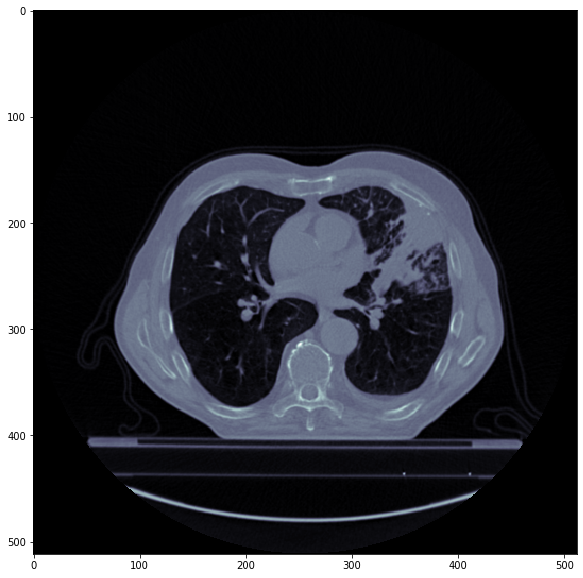

In [9]:
# the `cmap` argument specifies the colour map to use, "bone" is a good choice for CT and MR images
plt.imshow(sitk.GetArrayFromImage(middle_slice), cmap="bone")

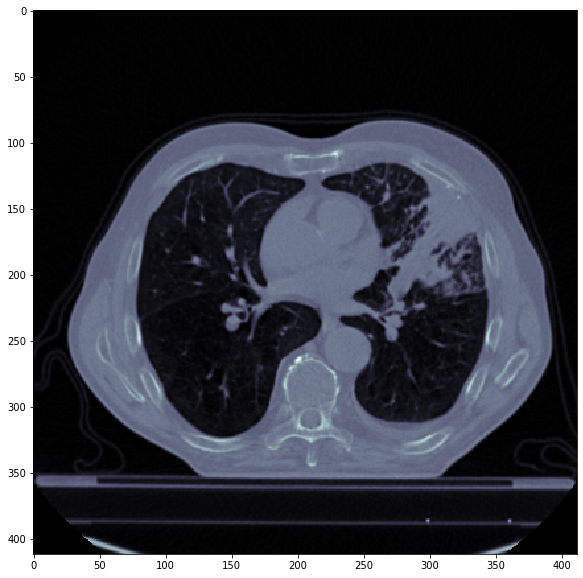

In [10]:
plt.imshow(sitk.GetArrayFromImage(cropped_middle_slice), cmap="bone")

By default, `matplotlib` will try to display the full range of grey level values in an image. It is often useful to limit the range of values to display, e.g. to enhance contrast in different tissue types or visually compare images with different ranges of values. The keyword arguments `vmin` and `vmax` can be used to restrict the range of displayed values.

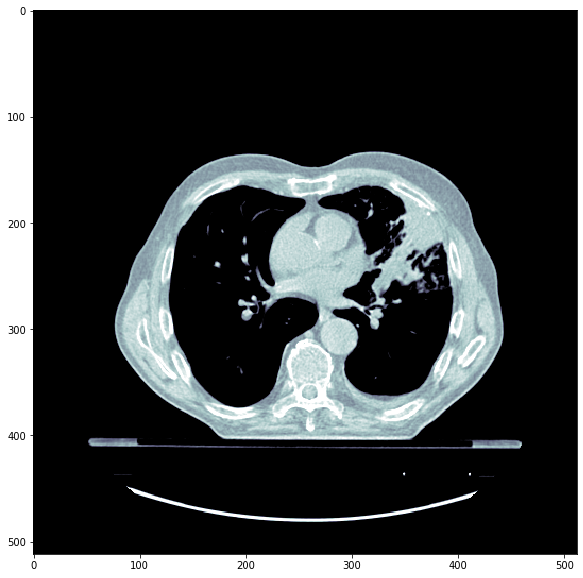

In [11]:
# restrict the range of displayed values to [-1000, 150]
plt.imshow(sitk.GetArrayFromImage(middle_slice), cmap="bone", vmin=-500, vmax=150)

Let's not forget that the CT scan is three-dimensional. Viewing 3D images on a 2D screen is tricky, and we'll not go too deep into available solutions. One simple and reliable method is to view several slices next to each other.

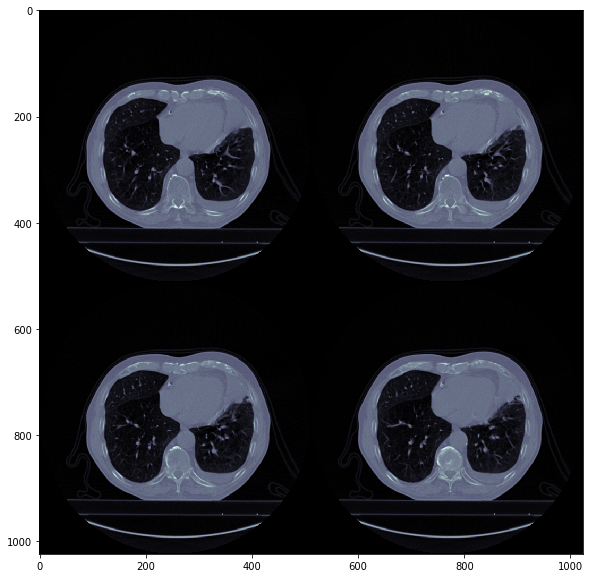

In [12]:
# the second argument here specifies the layout as [columns, rows]
slices = sitk.Tile([image[:, :, s] for s in range(50, 55)], [2, 2])
plt.figure(figsize=(20, 10))
plt.imshow(sitk.GetArrayFromImage(slices), cmap="bone")

Let's see what the segmentation mask looks like.

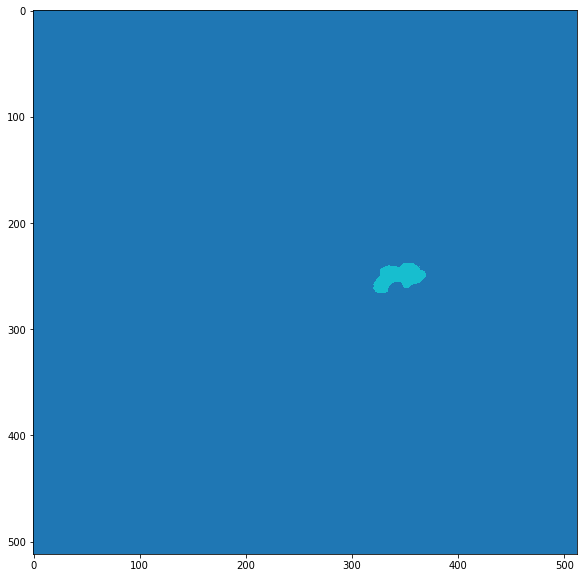

In [13]:
middle_seg_slice = segmentation[:, :, segmentation.GetSize()[2] // 2]
plt.imshow(sitk.GetArrayFromImage(middle_seg_slice), cmap="tab10")

It is often useful to overlay a segmentation mask on an image. Let's do it using `SimpleITK`.

In [14]:
def overlay_segmentation(image, segmentation):
    if isinstance(image, sitk.Image):
        image = sitk.GetArrayFromImage(image)
    if isinstance(segmentation, sitk.Image):
        segmentation = sitk.GetArrayFromImage(segmentation)

    overlay = np.ma.masked_where(segmentation == 0, segmentation)
    plt.imshow(image, cmap="bone", vmin=-1000, vmax=150)
    plt.imshow(overlay, cmap="tab10", vmin=0, vmax=1)

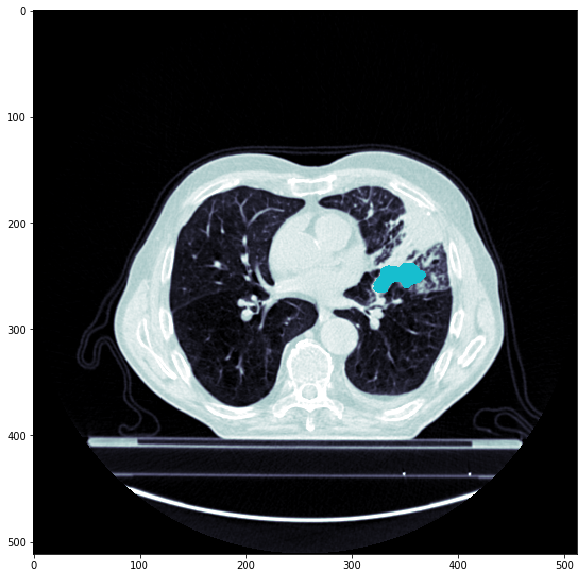

In [15]:
overlay_segmentation(middle_slice, middle_seg_slice)

## Resampling images

Resampling refers to sampling an already-sampled image, possibly at different locations. It is the basis of most geometric transformations on image coordinates (resizing, rotating, etc.). We'll have a look at 3 different examples:
- changing image spacing to desired value
- changing image size to desired value
- rotating an image.

### Changing image spacing

Resampling an image requires specifying 4 components:
- the resampled grid, specified using origin, direction and spacing
- the size of the resampled image
- the interpolator, used to fill in values between pixels
- the transformation to apply to coordinates before resampling.

Let's start by resampling the image to (2 mm, 2 mm, 2 mm) voxel spacing.

In [16]:
new_spacing = (2., 2., 2.)
new_origin = image.GetOrigin() # keep the same origin and direction
new_direction = image.GetDirection()

original_size = np.array(image.GetSize())
original_spacing = np.array(image.GetSpacing())

# since we want to preserve the whole image region, we can calculate the new size as
# the original size times the spacing ratio rounded to the nearest integer
new_size = np.floor(original_size * original_spacing / np.array(new_spacing)).astype(np.int).tolist()

# set up the resampling filter...
resampler = sitk.ResampleImageFilter()
resampler.SetOutputOrigin(new_origin)
resampler.SetOutputDirection(new_direction)
resampler.SetOutputSpacing(new_spacing)
resampler.SetSize(new_size)
resampler.SetInterpolator(sitk.sitkLinear) # use trilinear interpolation

# ...and apply it to the image
resampled_image = resampler.Execute(image)

In [17]:
print(f"resampled image image:\n\tsize = {resampled_image.GetSize()}\n\torigin = {resampled_image.GetOrigin()}\n\tdirection = {resampled_image.GetDirection()}\n\tspacing = {resampled_image.GetSpacing()}")

resampled image image:
	size = (250, 250, 201)
	origin = (-249.51171875, -460.51171875, -681.5)
	direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
	spacing = (2.0, 2.0, 2.0)


Let's also resample the segmentation. Note that for resampling segmentation maps with a discrete set of meaningful labels, it is advisable to use *nearest neighbour* instead of linear interpolation, since it doesn't introduce new values into the image. For example, in our segmentation 1 denotes tumour and 0 denotes background. Linear interpolation between 0 and 1 produces .5, which does not correspond to a meaningful label.

In [18]:
resampler.SetInterpolator(sitk.sitkNearestNeighbor) # use nearest neighbour interpolation
resampled_segmentation = resampler.Execute(segmentation)

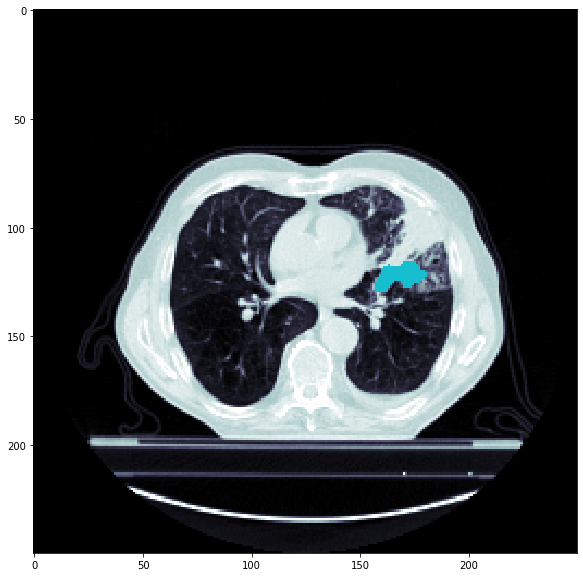

In [19]:
resampled_image_slice = resampled_image[:, :, new_size[2] // 2]
resampled_segmentation_slice = resampled_segmentation[:, :, new_size[2] // 2]

overlay_segmentation(resampled_image_slice, resampled_segmentation_slice)

### Changing image size

Now we'll use interpolation to change image size to (256 px, 256 px, 134 px). This is just like what we've done previously, but now we need to calculate the new spacing given the required size.

In [20]:
new_size = (256, 256, 134)

original_size = np.array(image.GetSize())
original_spacing = np.array(image.GetSpacing())

# since we want to preserve the whole image region, we can calculate the new spacing
# the original spacing times the size ratio (no rounding this time, since fractional spacing is allowed)
new_spacing = original_spacing * original_size / np.array(new_size).tolist()

resampler.SetOutputSpacing(new_spacing)
resampler.SetSize(new_size)
resampler.SetInterpolator(sitk.sitkLinear)
resampled_image = resampler.Execute(image)

resampler.SetInterpolator(sitk.sitkNearestNeighbor)
resampled_segmentation = resampler.Execute(segmentation)

In [21]:
print(f"resampled image image:\n\tsize = {resampled_image.GetSize()}\n\torigin = {resampled_image.GetOrigin()}\n\tdirection = {resampled_image.GetDirection()}\n\tspacing = {resampled_image.GetSpacing()}")

resampled image image:
	size = (256, 256, 134)
	origin = (-249.51171875, -460.51171875, -681.5)
	direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
	spacing = (1.953125, 1.953125, 3.0)


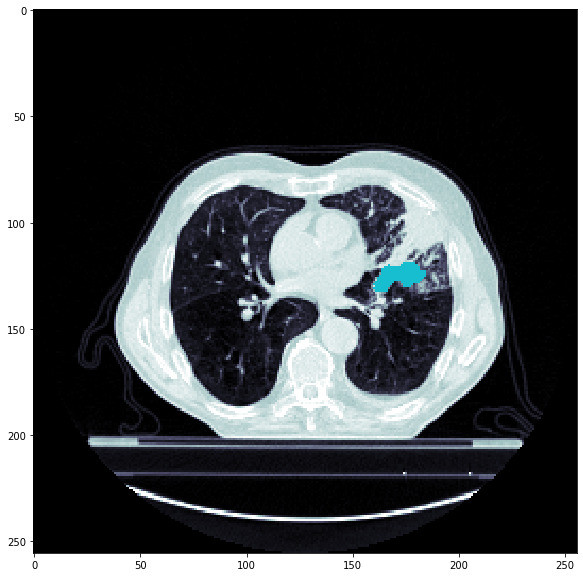

In [22]:
resampled_image_slice = resampled_image[:, :, new_size[2] // 2]
resampled_segmentation_slice = resampled_segmentation[:, :, new_size[2] // 2]

overlay_segmentation(resampled_image_slice, resampled_segmentation_slice)

### Rotations

So far, we have used the default transformation, which is the identity (i.e. do nothing) transformation. Let's see what happens when we apply a 3D rotation transformation to the coordinates when resampling. This can be accomplished using `sitk.Euler3DTransform`, which performs a 3D rotation about a given centre (with optional translation).

In [23]:
# let's use the centre of image as the centre of rotation (notice it has to be given in world coordinates)
rotation_centre = image.TransformIndexToPhysicalPoint((np.array(image.GetSize()) // 2).tolist())

rotation = sitk.Euler3DTransform(
    rotation_centre, # this specifies the centre of rotation in world coordinates
    0.,              # the angle of rotation around the x-axis, in radians -> coronal rotation
    0.,              # the angle of rotation around the y-axis, in radians -> saggittal rotation
    np.pi / 4,       # the angle of rotation around the z-axis, in radians -> axial rotation
    (0., 0., 0.)     # optional translation (shift) of the image, here we don't want any translation
)

# keep the same origin, direction, spacing and size
new_origin = image.GetOrigin()
new_direction = image.GetDirection()
new_spacing = image.GetSpacing() 
new_size = image.GetSize()

resampler.SetOutputOrigin(new_origin)
resampler.SetOutputDirection(new_direction)
resampler.SetOutputSpacing(new_spacing)
resampler.SetSize(new_size)
resampler.SetInterpolator(sitk.sitkLinear) # use trilinear interpolation
resampler.SetTransform(rotation)
resampler.SetDefaultPixelValue(-1000) # let's fill the pixels outside the image domain with air
rotated_image = resampler.Execute(image)

Let's also rotate the segmentation, remembering to use nearest neighbour interpolation.

In [24]:
resampler.SetInterpolator(sitk.sitkNearestNeighbor)
resampler.SetDefaultPixelValue(0) # fill the pixels outside the domain with background label
rotated_segmentation = resampler.Execute(segmentation)

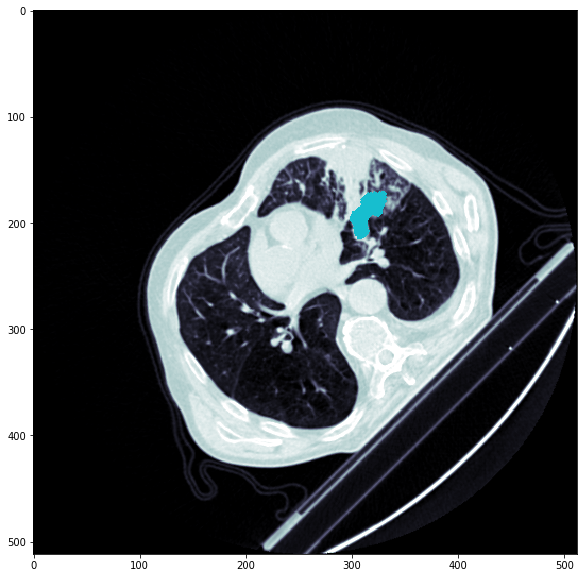

In [25]:
rotated_image_slice = rotated_image[:, :, new_size[2] // 2]
rotated_segmentation_slice = rotated_segmentation[:, :, new_size[2] // 2]

overlay_segmentation(rotated_image_slice, rotated_segmentation_slice)

## Intensity transformations

### Pixel-wise mathematical operations
`SimpleITK` overloads most common mathematical operators to act on all pixels in an image. This makes it possible to do simple arithmetic just like with `numpy` arrays.

In [26]:
# add a constant value to every pixel, subtraction works the same
image_add = image + 1024
print(f"{image[0, 0, 0]} + 1024 = {image_add[0, 0, 0]}")

-1024 + 1024 = 0


In [27]:
# multiply every pixel by a constant value, division works the same
image_mul = image * -1 
print(f"{image[0, 0, 0]} * -1 = {image_mul[0, 0, 0]}")

-1024 * -1 = 1024


In [28]:
# mathematical operations are also possible between images, as long as they occupy the same physical space
image_squared = image * image
print(f"{image[0, 0, 0]} * {image[0, 0, 0]} = {image_squared[0, 0, 0]}")

-1024 * -1024 = 1048576


### Thresholding
We will now use pixel-wise mathematical operations to threshold the image. Adipose tissue (fat) usually takes values between -150 and -50 Hounsfield units in a CT scan. Let's create a binary image, where 1 = adipose tissue and 0 = other.

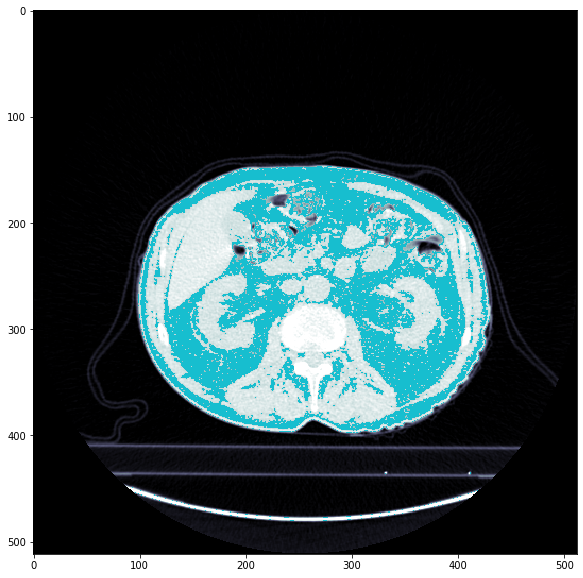

In [29]:
lower = -150
upper = -50
adipose_mask = (image >= lower) & (image <= upper)
slice_location = 3 # let's pick a slice in the abdominal area, which has more fat
overlay_segmentation(image[:, :, slice_location], adipose_mask[:, :, slice_location])

## Filtering
Filtering refers to altering the intensity values in an image to achieve a particular effect using a specific operator called a *filter*. We will look at 3 filtering tasks:
- blurring the image with the Gaussian filter
- reducing noise using the median filter
- detecting edges using the Sobel filter.

Although all of those filters work in 3D, we will restrict the image to a single slice to speed up processing.

In [30]:
image_slice = image[:, :, image.GetSize()[2] // 2]

### Blurring with Gaussian filter

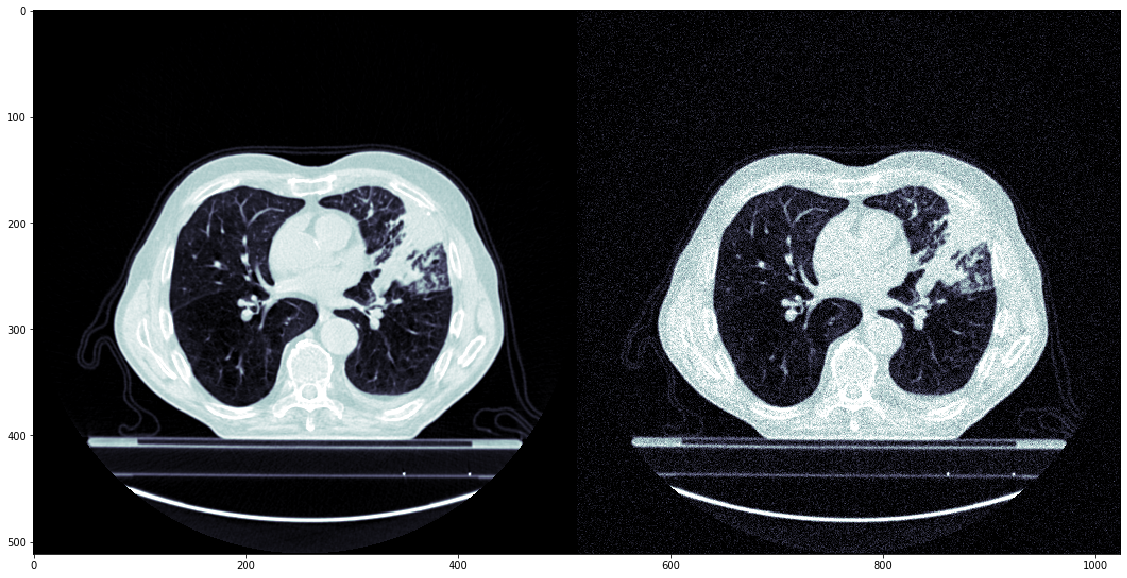

In [31]:
# additive Gaussian noise adds a small random number sampled iid from a normal distribution
# to each pixel value; this will make the filtering effects more visible
image_with_noise = sitk.AdditiveGaussianNoise(image_slice, 100)
images = sitk.Tile([image_slice, image_with_noise], [2, 1])
plt.figure(figsize=(20, 10))
plt.imshow(sitk.GetArrayFromImage(images), cmap="bone", vmin=-1000, vmax=150)

Gaussian filter blurs the image by replacing each image pixel by the average of values in a window around it weighted by a Gaussian function (this gives more importance to pixels close by and less importance to more distant neighbours). The filter has one parameter $\sigma$, which specifies the standard deviation of the Gaussian weighting function. Let's see how changing $\sigma$ affects the output image.

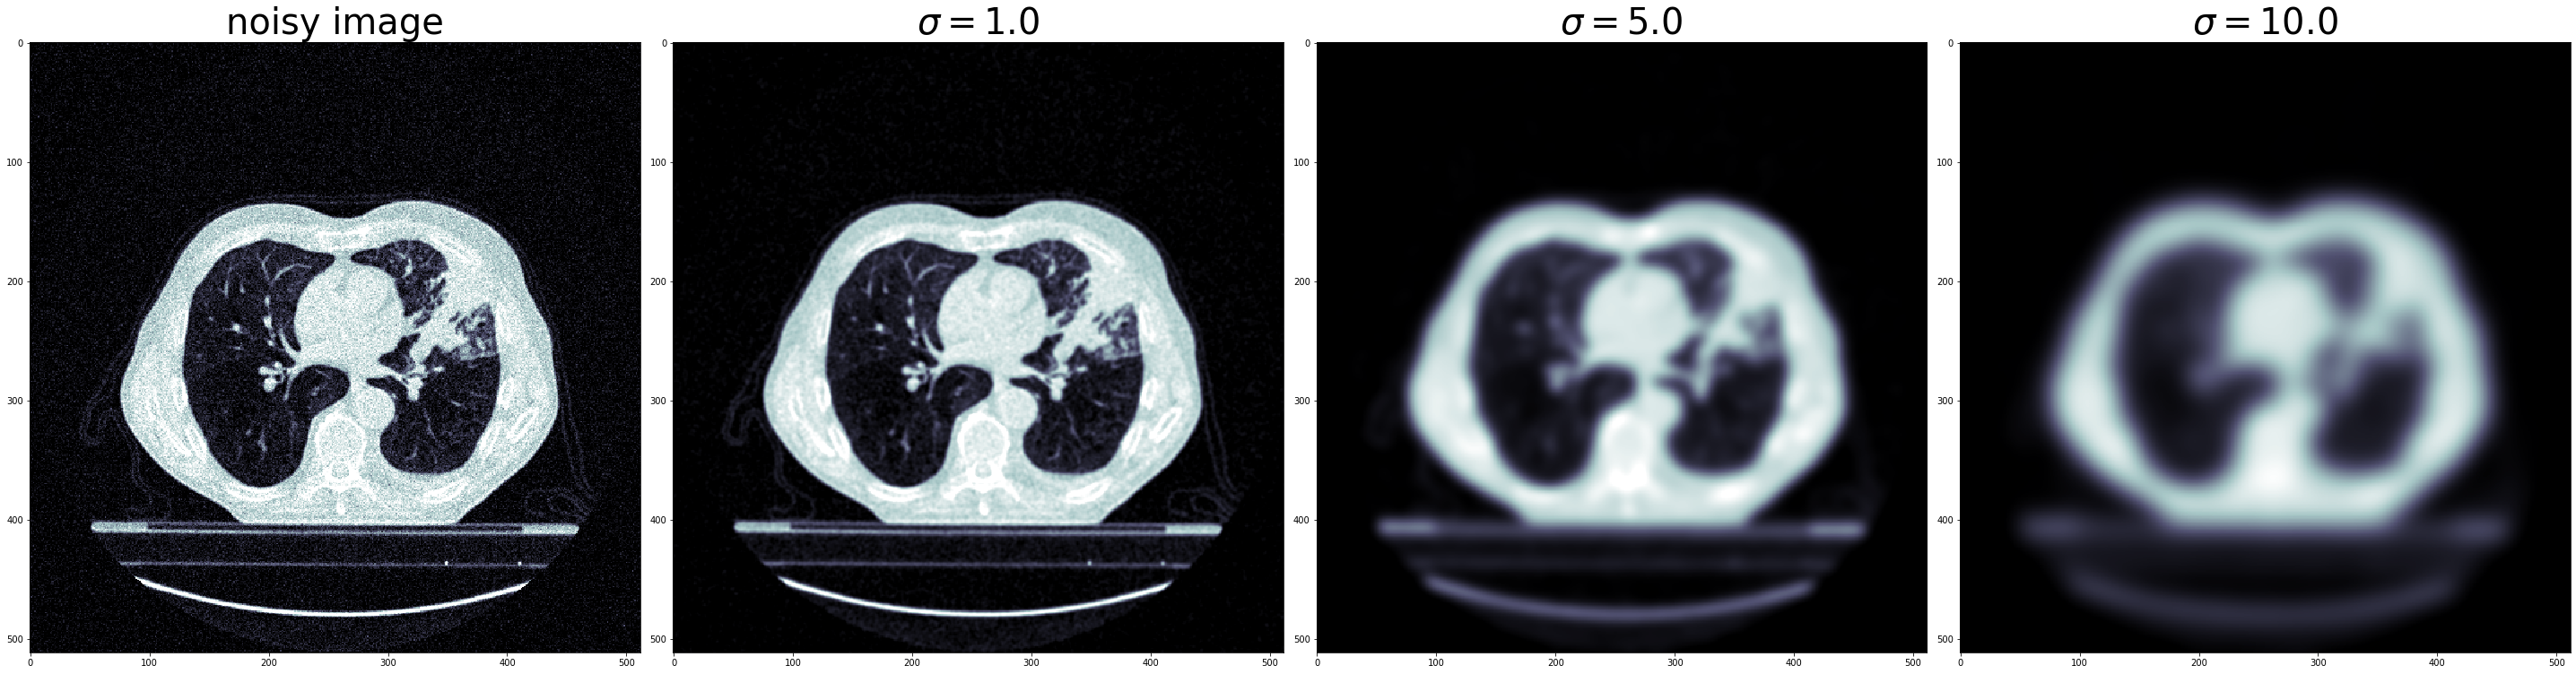

In [32]:
sigmas = [1., 5., 10.]

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax[0].imshow(sitk.GetArrayFromImage(image_with_noise), cmap="bone", vmin=-1000, vmax=150)
ax[0].set_title("noisy image", fontsize=40)

for a, sigma in zip(ax[1:], sigmas):
    blurred_image = sitk.SmoothingRecursiveGaussian(image_with_noise, sigma)
    a.imshow(sitk.GetArrayFromImage(blurred_image), cmap="bone", vmin=-1000, vmax=150)
    a.set_title(f"$\sigma = {sigma}$", fontsize=40)
fig.tight_layout()

Notice how the image gets progressively less noisy, but also more blurry. In particular, edges between objects become "smeared out". Identifying optimal $\sigma$ is important if you want to remove noise using the Gaussian filter.

### Removing noise with median filter
A different way to remove noise from the image is to use the median filter. It works by replacing each pixel with the median of values in a window around it. It is less sensitive to outliers (= relatively large or small values) than the Gaussian filter, and also tends to preserve edges better. It has one parameter, determining the size of the window to take the median over.

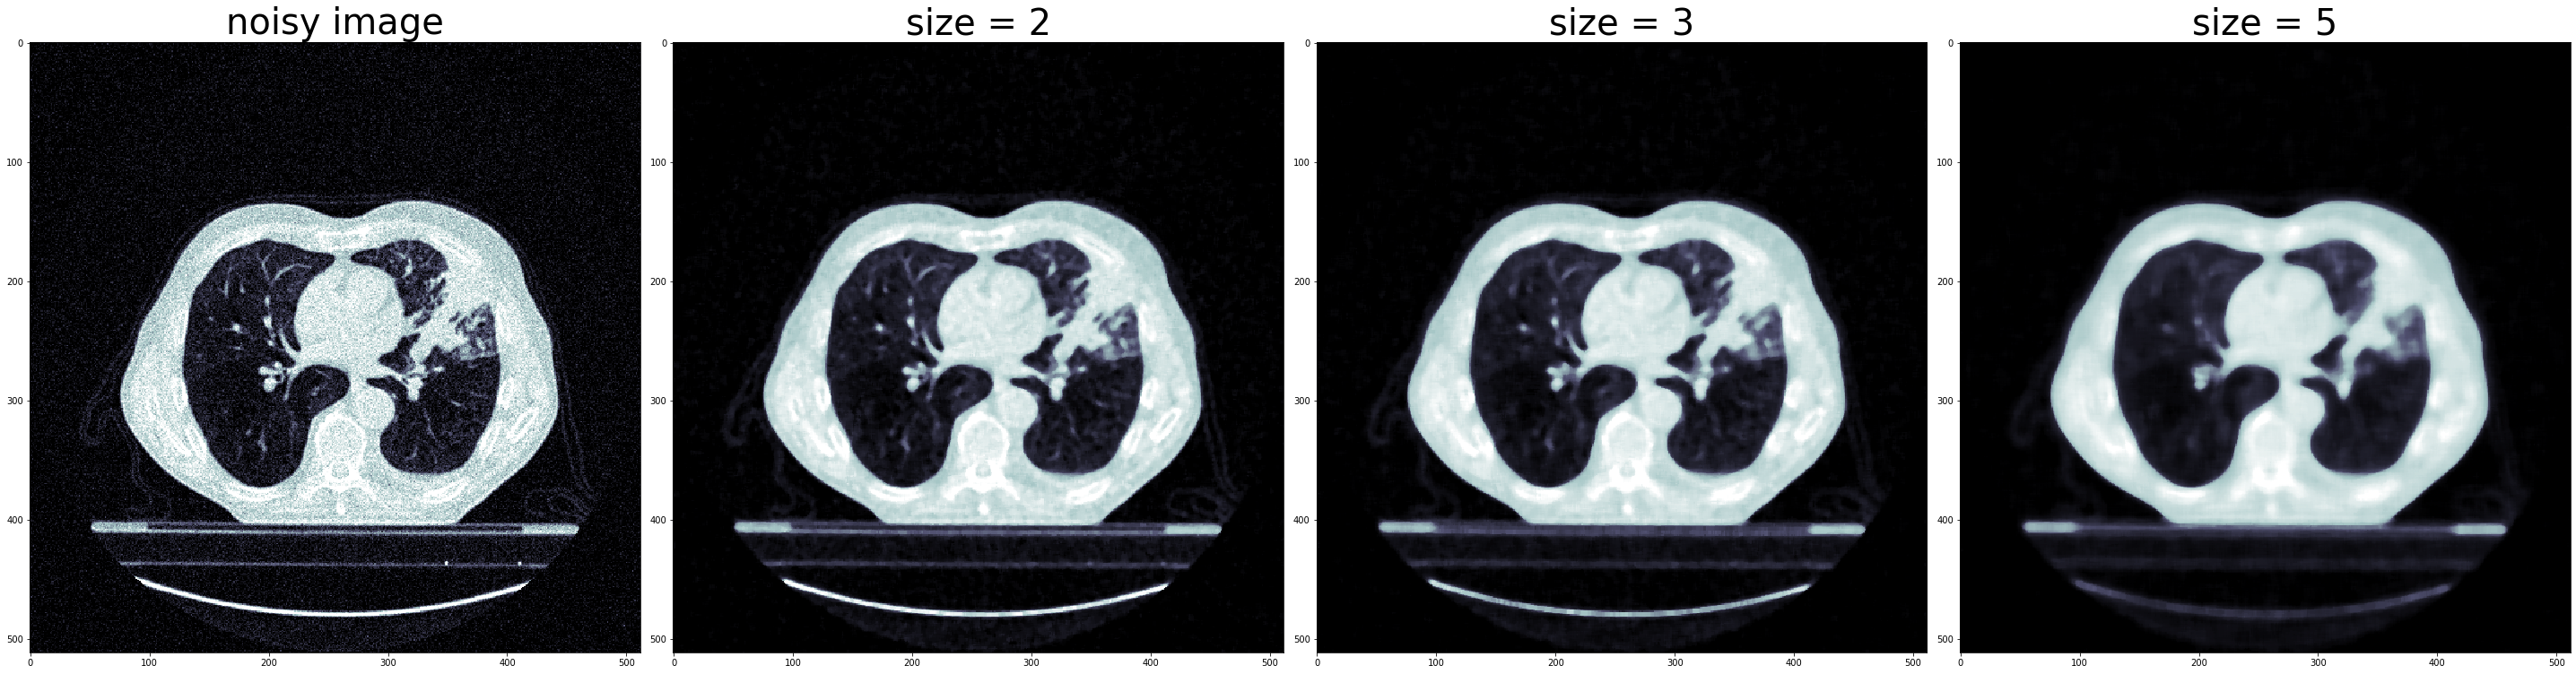

In [33]:
sizes = [2, 3, 5]

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax[0].imshow(sitk.GetArrayFromImage(image_with_noise), cmap="bone", vmin=-1000, vmax=150)
ax[0].set_title("noisy image", fontsize=40)

for a, size in zip(ax[1:], sizes):
    blurred_image = sitk.Median(image_with_noise, [size, size])
    a.imshow(sitk.GetArrayFromImage(blurred_image), cmap="bone", vmin=-1000, vmax=150)
    a.set_title(f"size = {size}", fontsize=40)
fig.tight_layout()

### Edge detection with the Sobel filter
Edges in an image are sharp changes in intensity, often corresponding to boundaries between objects or parts of an object. Detecting edges is a very useful operation, often done as an intermediate step of image segmentation or feature extraction. The Sobel filter is one edge detection method, using (in rough terms) the first derivative of the intensity values in the image.

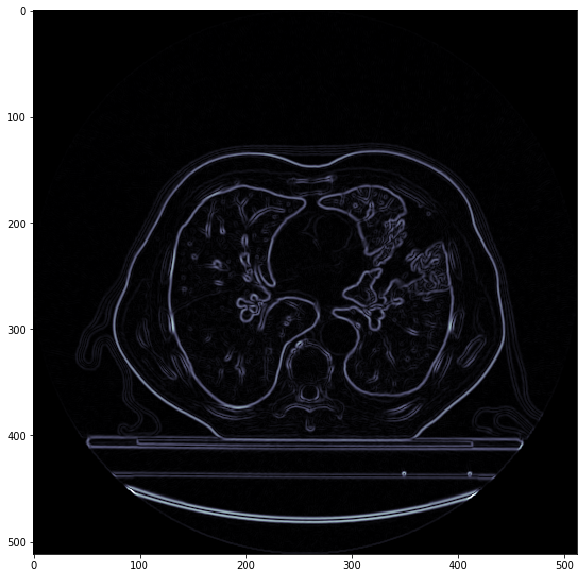

In [34]:
image_slice = sitk.Cast(image_slice, sitk.sitkFloat64) # need to convert to floating point type to work with the Sobel filter
edge_image = sitk.SobelEdgeDetection(image_slice)
plt.imshow(sitk.GetArrayFromImage(edge_image), cmap="bone")

Notice how edges appear as bright lines in the filtered image, with sharper edges (e.g. between the body and air) having higher intensity.

There is a lot more to filtering than what we covered here. To learn more about image filtering, including how they are computed using 2D convolution, check out [this amazing visualization](http://setosa.io/ev/image-kernels/).

## Saving images
Let's finish on a similar note as we started with, and save one of our processed images to a file. Just like in the case of reading, SimpleITK supports saving images in multiple formats (although using the DICOM format requires some knowledge of the DICOM standard, which we won't go into here).

We will save the rotated image and mask in the `NRRD` format. This only requires specifying the right file extension.

In [35]:
import os

processed_path = os.path.join("data", "processed")
os.makedirs(processed_path, exist_ok=True)

sitk.WriteImage(rotated_image, os.path.join(processed_path, "rotated_image.nrrd"))
sitk.WriteImage(rotated_segmentation, os.path.join(processed_path, "rotated_segmentation.nrrd"))